# 同花顺行业概念信息

In [1]:

import pandas as pd

fpath = r'../../JohnsonUtil\wencai\同花顺板块行业.xls'
thsgn = pd.read_excel(fpath)
thsgn = thsgn.set_index('股票代码')

## 查询信息

In [2]:
thsgn[:1]
thsgn.columns
thsgn.loc['300474.SZ']

股票简称                                                                  景嘉微
现价(元)                                                                  60
涨跌幅(%)                                                              -1.06
主营产品名称                  图形显控领域产品||小型专用化雷达领域产品||小型专业化雷达||图形显控模块产品||加固类产...
所属概念                    显卡;AI芯片;军民融合;雷达;深股通;人工智能;芯片设计;芯片概念;集成电路概念;军工;超...
所属同花顺行业                                                    国防军工-国防军工-军工电子
经营范围                    电子产品（不含电子出版物）、计算机软件的研究、开发、生产和销售及其相关的技术服务，集成电路设...
公司网站                                                 www.jingjiamicro.com
所属概念数量(个)                                                              19
a股流通市值 (元)2023.01.31                                          19023863000
Name: 300474.SZ, dtype: object

# Debug开启

In [3]:

# Delete Jupyter notebook root logger handler
# Set Debug
import logging
import sys

# %matplotlib inline
%matplotlib widget
# stdi, stdo, stde = sys.stdin, sys.stdout, sys.stderr
# # # reload(sys)
# # # sys.setdefaultencoding('utf-8')
# sys.stdin, sys.stdout, sys.stderr = stdi, stdo, stde

# stdout = sys.stdout
# sys.path.append('../')
# import JSONData.tdx_data_Day as tdd
# sys.stdout = stdout


mylogger = logging.getLogger()
if len(mylogger.handlers) > 0:
    for ix in mylogger.handlers:
        print("handlers:%s std:%s" % (ix.stream, sys.stdout))
else:
    print("nb not handlers")
#     mylogger.propagate = False
mylogger.setLevel(logging.ERROR)
# mylogger.setLevel(logging.DEBUG)

print("nb:", sys.stderr)
# # Create logger as usual
import nest_asyncio

nest_asyncio.apply()

nb not handlers
nb: <ipykernel.iostream.OutStream object at 0x000001EFD94C5190>


# TDX多日数据分析

## 定义 TDX-Path

In [4]:
# encoding:utf-8
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
# InteractiveShell.ast_node_interactivity = "last_expr"

import sys

import pandas as pd
from pandas import HDFStore

stdi, stdo, stde = sys.stdin, sys.stdout, sys.stderr
# print(stdi, stdo, stde)
# reload(sys)
# sys.setdefaultencoding('utf-8')
# sys.stdin, sys.stdout, sys.stderr = stdi, stdo, stde

# print(sys.stdout,sys.stderr,sys.stderr)

# print(stdi, stdo, stde)

# sys.stdin, sys.stdout, sys.stderr = stdi, stdo, stde
# print(stdi, stdo, stde)

In [5]:
sys.path.append("../../")
import os

import JSONData.tdx_data_Day as tdd
# import win_unicode_console
from JohnsonUtil import commonTips as cct
from JSONData import sina_data

os.environ['NUMEXPR_MAX_THREADS'] = '12'

# import nest_asyncio
# nest_asyncio.apply()
# 查阅资料后发现，发现使用 jupyter notebook 环境，其连接着 IPython 内核，而 IPython 内核本身在事件循环上运行，而 asyncio 不允许嵌套其事件​​循环，因此会出现如上图的错误信息。
# nest_asyncio 作为异步操作的补丁而存在，具体内容请参考
# win_unicode_console.disable()
tdx_path = "G:\\tdx_last_df.h5"
sina_MultiD_path = "G:\\sina_MultiIndex_data.h5"
sina_d_path = "G:\\sina_data.h5"
sina_dd_path = "G:\\get_sina_all_dd.h5"
# print(stdi, stdo, stde)
sys.stdin, sys.stdout, sys.stderr = stdi, stdo, stde

# # 显示所有列
pd.set_option("display.max_columns", None)
# # 显示所有行
# pd.set_option('display.max_rows', None)
# # 设置 value 的显示长度为 100，默认为 50
# pd.set_option('max_colwidth',100)
# pd.set_option?
# df.columns.tolist()

In [6]:
cct.code_to_symbol_ths('000002')

'000002.SZ'

### 功能定义

In [7]:
def apply_col_toint(df, col=None):
    if col is None:
        co2int = ['boll', 'op', 'ratio', 'fib', 'fibl', 'df2']
    # co2int.extend([co for co in df.columns.tolist()
    #                if co.startswith('perc') and co.endswith('d')])
        co2int.extend(['top10', 'topR'])
    else:
        co2int = col
    co2int = [inx for inx in co2int if inx in df.columns]

    for co in co2int:
        df[co] = df[co].astype(int)

    return df


def readHdf5(fpath, root=None):
    store = pd.HDFStore(fpath, "r")
    print(store.keys())
    if root is None:
        root = store.keys()[0].replace("/", "")
    df = store[root]
    df = apply_col_toint(df)
    store.close()
    return df


def write_code_to_blk(codew, blk='090'):
    block_path = tdd.get_tdx_dir_blocknew() + '%s.blk' % (blk)
    write_blk = 'n'
    write_blk = cct.cct_raw_input("write blk [Y] or [N]:")
    if write_blk == 'y' or write_blk == 'Y':
        hdf5_wri = cct.cct_raw_input(
            "Rewrite code [Y] or append [N](defalut:N):")
        if hdf5_wri == 'y' or hdf5_wri == 'Y':
            append_status = False
        else:
            append_status = True
        if len(codew) > 3:
            cct.write_to_blocknew(block_path, codew, append_status,
                                  doubleFile=False, keep_last=0)
            ("write:%s block_path:%s" % (len(codew), block_path))
        else:
            ("write error:%s block_path:%s" % (len(codew), block_path))


def show_tdx_data(df, codelist=None, market_value='3', col=None):

    columns_ = [
        "name", "category", "close", "percent",'volra', 'topR', "lastp1d", "ma5dcum",
        "ma20d", "fib", "fibl", "ra", "ral", "df2", "per1d", "hmax", "lmin",
        "per%sd" % (market_value),
        "perc%sd" % (market_value)]
    if isinstance(df, pd.Series):
        columns_ = [co for co in columns_ if co in df.index]
    else:
        columns_ = [co for co in columns_ if co in df.columns]
    if col is not None:
        columns_.insert(4, col)

    if codelist is None:
        if isinstance(df, pd.Series):
            # print("Count:1")
            temp = df.loc[columns_]
        else:
            print("Count:%s %s" % (df.shape))
            temp = df.loc[:, columns_]
    else:
        temp = df.loc[[x for x in codelist if x in df.index], columns_]
    return temp


def compute_perd_value(df, market_value=3, col="per"):

    # if market_value == None or market_value < "2":
    #     market_value = 3
    # if market_value > 1 and len(df[ df["%s%sd" % (col, market_value)] > 2])   :
    market_value = str(market_value)
    if market_value > str(1):
        temp = df[
            df.columns[
                (df.columns >= "%s1d" % (col))
                & (df.columns <= "%s%sd" % (col, market_value))
            ]
        ]

        df['%s%sd' % (col, market_value)] = temp.T.sum().apply(
            lambda x: round(x, 1))
    else:
        print("market_value <= 1,No Compute")

    return df


def clean_688(df):
    df = df[(~df.index.str.contains("688"))]
    return df


from collections import Counter, OrderedDict


def counterCategory(df):
    top5 = dict()
    if len(df) > 0:
        categoryl = df.category[:20].tolist()
        dicSort = []
        for i in categoryl:
            if isinstance(i, str):
                # dicSort.extend([ co.decode('utf8') for co in i.split(';')])
                dicSort.extend(i.split(';'))
                # cate_list = i.split(';')
                # for co in cate_list:
                #     dicSort.append(to_str(co))
        topSort = Counter(dicSort)
        top5 = OrderedDict(topSort.most_common(5))
        # for i in top5.keys():
        # print(i, top5[i]),
        # print('')
    # for i in top5.keys():
    #     # print(u"板块:%s %s " % (i.decode('utf8'), (topSort[i]))),
    #     # print(u"板块:%s count:%s" % (i, (topSort[i]))),
    #     print(i, (topSort[i]))

    return top5


def get_runtime_percent(df, perd=None):
    if "percent" not in df.columns and "lastp1d" in df.columns:
        # print('init percent')
        df = df.fillna(0)
        df['percent'] = list(
            map(
                lambda x, y, z: round((x - y) / y * 100, 1)
                if x != y else round((x - z) / z * 100, 1),
                df.close, df.lastp1d, df.lastp2d))
        # df['percent'] = df.apply(lambda x: round((x.close - x.lastp1d) /(x.lastp1d) * 100, 1),axis=1)
    # else:
    #     print('Percent in columns')
    if not perd is None:
        df[perd] = list(map(lambda x, y: round((x + y), 1)
                            if int(y) > 0 else 0, df.perd, df.percent))
    return df


def get_realtime_ratio(df, market='all'):
    if 'ratio' in df.columns:
        df.drop('ratio', axis=1, inplace=True)
    ratio_df = tdd.getSinaJsondf(market)
    df = cct.combine_dataFrame(
        df, ratio_df.ratio, col=None, compare=None, append=False, clean=False)
    return df


def get_ths_info(code):
    code = cct.code_to_symbol_ths(code)
    return thsgn.loc[code]

### 还原Cell输出信息

In [8]:
# sys.stdin, sys.stdout, sys.stderr = stdi, stdo, stde
# print(stdi, stdo, stde)

## 初始化 hdf5的tdx数据

In [9]:

market_value = "3"
df = readHdf5(tdx_path)
df = tdd.get_sina_datadf_cnamedf(df.index.tolist(), df)
df = compute_perd_value(df, market_value, "perc")
df = compute_perd_value(df, market_value, "per")

df = get_realtime_ratio(df)
# df=get_runtime_percent(df)

df = get_runtime_percent(df, "per%sd" % (market_value))

# filter 科创
df = clean_688(df)

df.shape
df[-1:].percent
df[~(df.last6vol > 0)][:10].last6vol
df.ratio[-2:]

['/low_d_60_y_all', '/low_w_180_y_all']


(4355, 119)

code
600406   -2.2
Name: percent, dtype: float64

Series([], Name: last6vol, dtype: float64)

code
600886    0.5
600406    0.2
Name: ratio, dtype: float64

### test InStock

In [10]:
df.columns

Index(['lopen', 'lhigh', 'llow', 'lastp', 'lvol', 'lamount', 'ma5d', 'ma10d',
       'ma20d', 'upper',
       ...
       'lv', 'date', 'lowvol', 'last6vol', 'category', 'timel', 'close',
       'name', 'ratio', 'percent'],
      dtype='object', length=119)

## 个股数据查看

In [11]:
df.ma203d[:1]
# df.loc['003042'].loc[["category", "close"]]

code
301267    41.35
Name: ma203d, dtype: float64

In [12]:
show_tdx_data(df.loc['003042'])
get_ths_info('003042')

name                  中农联合
category    新股与次新股 ;核准制次新股
close                18.43
percent                1.0
topR                     0
lastp1d              18.25
ma5dcum               18.3
ma20d                18.28
fib                     16
fibl                     2
ra                     0.0
ral                  -17.5
df2                      0
per1d                  1.0
hmax                 21.76
lmin                 17.96
per3d                  2.0
perc3d                 1.8
Name: 003042, dtype: object

股票简称                                                                 中农联合
现价(元)                                                               26.24
涨跌幅(%)                                                               0.92
主营产品名称                  吡虫啉||啶虫脒||烯啶虫胺||哒螨灵||低毒农药原药及其中间体||杀虫剂||杀菌剂||除草...
所属概念                                                  草甘膦;乡村振兴;中俄贸易概念;供销社
所属同花顺行业                                                      基础化工-化学制品-农药
经营范围                    生物、化学农药、化工产品及仪器仪表的技术开发、技术转让、技术咨询服务；农药（不含化学危险品）...
公司网站                                                       www.sdznlh.com
所属概念数量(个)                                                               4
a股流通市值 (元)2023.01.31                                           1787252200
Name: 003042.SZ, dtype: object

In [13]:
# df[(df.close > df.ma20d * 0.99) & (df.close < df.ma20d * 1.05)]

def filter_ma_range_df(df, ma='20', days='3'):
    dd = []
    for da in range(int(days), 0, -1):
        # print(da, ma)
        # df1 = df[ (df['lastp%sd'%(da)] > df['ma%s%sd'%(ma,da)]) & (df['lastp%sd'%(days)] < df['ma%s%sd'%(ma,da)] * 1.1)]
        df1 = df[(df['lastp%sd' % (da)] > df['ma%s%sd' % (ma, da)] * 0.99)]
        if da == days:
            dd = df1.index.tolist()
        else:
            dd = [x for x in dd if x in df1.index]

    return [x for x in set(dd)]


def get_union_list(maind, subd):
    # 筛选Main存在后切在新Sub出现
    return [x for x in maind if x in subd]

### 新农联合筛选

In [14]:
code_fs = '003042'
# show_tdx_data(df.loc['003042'])
# get_ths_info('003042')

df_f_t = df[(df.fib < 30) & (df.fibl > 6) & (df.df2 > 2) & (df.ral < -15) &
            (df.close >= df.ma5dcum) & (df.perc3d > 1.1) & (df.lastv1d > df.lastv2d) & (df.close > df.ma5d) ]

df_f_t.shape
# df_f_t.loc[code_fs][:1]
show_tdx_data(df_f_t)[:5]


(3, 119)

Count:3 119


,name,category,close,percent,topR,lastp1d,ma5dcum,ma20d,fib,fibl,ra,ral,df2,per1d,hmax,lmin,per3d,perc3d
code,,,,,,,,,,,,,,,,,,
301201,诚达药业,转融券标的 ;新股与次新股 ;,25.45,0.7,0,25.27,24.1,24.00,17,7,0.0,-15.3,3,5.3,29.09,23.52,0.0,2.9
300260,新莱应材,食品安全;塑化剂;芯片设备,34.26,-2.5,0,35.15,33.5,31.03,14,9,0.0,-15.4,11,4.7,39.91,30.94,0.0,3.1
000620,*ST新联,新型城镇化;参股民营银行;北京,1.74,-1.1,0,1.76,1.7,1.65,14,8,0.0,-15.4,3,4.8,2.02,1.58,0.0,3.1


#### 写入069

In [15]:
# write_code_to_blk(df_f_t.index, '069')

In [16]:
df_ma26d = filter_ma_range_df(df, ma=20, days=5)
# 连续3日在生命线上
# df_ma26d = df[(df.fibl > 1) & (df.ra > 5)]
len(df_ma26d)
df_ma5d = filter_ma_range_df(df, ma=5, days=5)

# 连续3日在生命线上
len(df_ma5d)
df_x = get_union_list(df_ma26d, df_ma5d)
df_5dx_20d = get_union_list(df_x, df[df.ma5d < df.ma20d].index)

show_tdx_data(df.loc[df_5dx_20d])

1847

1387

Count:28 119


,name,category,close,percent,topR,lastp1d,ma5dcum,ma20d,fib,fibl,ra,ral,df2,per1d,hmax,lmin,per3d,perc3d
code,,,,,,,,,,,,,,,,,,
601952,苏垦农发,玉米种业;粳稻;生物育种,12.07,0.8,-1,11.98,11.9,11.98,60,6,0.0,-6.6,0,0.3,12.72,11.70,0.0,3.0
603031,安孚科技,新零售;商超百货,46.52,0.7,0,46.52,46.7,46.61,58,2,6.0,-6.9,0,0.7,49.50,45.90,0.0,0.1
300067,安诺其,分散染料;PPP概念;污水处理,3.01,0.7,0,2.99,3.0,3.02,59,2,5.0,-5.7,0,0.0,3.16,2.96,0.0,-0.1
603117,ST万林,物流骨干网,3.39,0.3,0,3.39,3.4,3.41,23,4,3.0,-9.6,0,0.3,3.72,3.34,0.0,1.1
600261,阳光照明,参股券商;低碳;融资融券,3.55,-0.8,0,3.58,3.6,3.57,59,6,0.0,-7.5,0,0.8,3.84,3.50,0.0,1.1
002522,浙江众成,新材料概念;嘉兴土改;小额贷款,4.92,0.4,0,4.90,4.9,4.93,16,6,0.0,-6.1,0,0.2,5.18,4.87,0.0,0.0
600217,中再资环,固废处理;地方国资改革;并购重,4.73,0.2,0,4.72,4.7,4.74,6,6,0.0,-4.6,0,-0.4,4.94,4.56,0.0,3.0
000538,云南白药,参股券商;医疗改革;股权转让,53.73,0.5,0,53.48,53.7,53.44,60,6,0.0,-4.7,0,0.2,54.65,52.51,0.0,1.9
600917,重庆燃气,重庆自贸区;地方国资改革;股权,6.94,0.4,0,6.91,7.0,6.94,51,6,0.0,-5.6,0,-0.3,7.27,6.85,0.0,1.0


In [17]:
df.loc[["603068", '601377', '000725'],
       ["date", "name", "category", "percent", "close", "lastp1d", "ma5d",
        "ma5dcum", "ma20d", "fib", "fibl", "df2", "per1d", "hmax", "lmin",
        "ra", "ral", "vcall", "vcra", "vchange", "lvol", 'lv', 'lowvol',
        'last6vol', 'per%sd' % (market_value),
        'perc%sd' % (market_value),
        'perc4d']][: 3]

,date,name,category,percent,close,lastp1d,ma5d,ma5dcum,ma20d,fib,fibl,df2,per1d,hmax,lmin,ra,ral,vcall,vcra,vchange,lvol,lv,lowvol,last6vol,per3d,perc3d,perc4d
code,,,,,,,,,,,,,,,,,,,,,,,,,,,
603068,2023-08-25,博通集成,新股与次新股,-1.4,27.62,28.02,28.09,27.9,26.82,16,9,0,1.3,30.65,26.86,4.0,-9.6,226.6,1.0,37.6,1904700.0,854046.0,1917799.0,1383800.0,0.0,2.8,1.0
601377,2023-06-26,兴业证券,参股新三板;MSCI概念;融资,0.3,6.40,6.38,6.43,6.4,6.52,60,6,2,-0.6,7.27,6.32,0.0,-14.4,503.9,6.0,-0.4,45877096.0,10854007.0,72997724.0,35394901.0,0.0,1.9,1.0
000725,2023-08-25,京东方Ａ,国开行;物联网;OLED,-0.3,3.84,3.85,3.90,4.0,3.92,16,1,0,-0.8,4.37,3.85,6.0,-13.1,136.4,2.0,40.1,255727499.0,137521565.0,300231878.0,152148899.0,0.0,-0.1,0.0


In [18]:

sort_key2 = "per%sd" % (market_value)
df = df.sort_values(
    by=["perc%sd" % (market_value), sort_key2, "fib"], ascending=[0, 0, 1]
)
show_tdx_data(df)[: 5]

show_tdx_data(df)[-5:]
# df = df.sort_values(by=['perc%sd'%(market_value), 'per%sd'%(market_value),'fib'],ascending=[0,0,1])

Count:4355 119


,name,category,close,percent,topR,lastp1d,ma5dcum,ma20d,fib,fibl,ra,ral,df2,per1d,hmax,lmin,per3d,perc3d
code,,,,,,,,,,,,,,,,,,
601188,龙江交通,股权转让;中俄自贸区;低价股,4.93,10.0,1,4.48,3.5,3.51,59,5,0.0,10.1,3,10.0,3.50,3.13,20.0,3.3
600408,安泰集团,抗寒;煤化工;焦煤,3.42,10.0,1,3.11,2.5,2.50,59,4,0.0,9.9,5,10.0,2.64,2.44,20.0,3.3
000766,通化金马,抗癌;医疗改革;民营医院,13.52,7.8,4,12.54,8.4,7.78,60,6,0.0,10.0,14,10.0,7.47,7.26,17.8,3.3
300765,新诺威,新股与次新股 ;保健品,16.75,4.9,0,15.97,13.8,13.16,17,5,0.0,1.1,6,5.3,15.34,11.93,10.2,3.3
000752,*ST西发,啤酒;股权转让;大消费,10.64,5.0,5,10.13,8.3,8.40,58,7,0.0,0.3,26,5.0,9.62,7.65,10.0,3.3


Count:4355 119


,name,category,close,percent,topR,lastp1d,ma5dcum,ma20d,fib,fibl,ra,ral,df2,per1d,hmax,lmin,per3d,perc3d
code,,,,,,,,,,,,,,,,,,
002929,润建股份,雄安新区;5G;新股与次新股,34.37,-2.0,0,35.08,39.1,37.70,16,1,8.0,-20.8,3,-3.0,43.50,35.91,0.0,-3.3
300188,美亚柏科,禁毒概念;网络安全;搜索引擎,16.19,-0.8,0,16.32,17.5,17.36,20,1,9.0,-30.7,0,-2.1,20.79,16.55,0.0,-3.3
002527,新时达,电梯概念;深股通;工业机器人,11.84,0.9,0,11.73,13.3,13.27,34,1,9.0,-22.1,9,-3.3,14.20,11.94,0.0,-3.3
603666,亿嘉和,机器人概念 ;新股与次新股 ;,30.11,2.0,0,29.52,31.9,31.66,14,1,6.0,-37.1,0,-3.0,45.15,30.10,-1.0,-3.3
002771,真视通,军民融合,13.80,1.0,-1,13.66,17.2,16.62,2,1,8.0,-30.7,5,-6.4,19.05,14.02,-5.4,-3.3


## filter 20D 涨幅榜 

In [19]:
# df = df[(df['close'] > df['ma20d'] * 0.98) & (df['close'] < df['ma20d'] * 1.03)]
f20df = df[(df['close'] > df['ma20d'] * 0.98)
           & (df['df2'] > 0) & (df['lastp1d'] > df['ma5d']) & (df['lasth1d'] >= df['lasth2d']) ]

f20df.shape
show_tdx_data(f20df)[: 3]
show_tdx_data(f20df)[-3:]

(304, 119)

Count:304 119


,name,category,close,percent,topR,lastp1d,ma5dcum,ma20d,fib,fibl,ra,ral,df2,per1d,hmax,lmin,per3d,perc3d
code,,,,,,,,,,,,,,,,,,
601188,龙江交通,股权转让;中俄自贸区;低价股,4.93,10.0,1,4.48,3.5,3.51,59,5,0.0,10.1,3,10.0,3.50,3.13,20.0,3.3
600408,安泰集团,抗寒;煤化工;焦煤,3.42,10.0,1,3.11,2.5,2.50,59,4,0.0,9.9,5,10.0,2.64,2.44,20.0,3.3
000766,通化金马,抗癌;医疗改革;民营医院,13.52,7.8,4,12.54,8.4,7.78,60,6,0.0,10.0,14,10.0,7.47,7.26,17.8,3.3


Count:304 119


,name,category,close,percent,topR,lastp1d,ma5dcum,ma20d,fib,fibl,ra,ral,df2,per1d,hmax,lmin,per3d,perc3d
code,,,,,,,,,,,,,,,,,,
301290,东星医疗,0,32.38,0.6,0,32.19,31.9,31.48,17,6,0.0,-17.0,4,2.5,37.15,31.19,0.0,0.0
300911,亿田智能,融资融券 ;转融券标的 ;新股,39.70,0.8,0,39.37,40.4,39.09,40,2,7.0,-9.1,3,4.3,41.13,37.46,0.0,0.0
002995,天地在线,今日头条概念 ;腾讯概念 ;云,26.28,0.8,0,26.07,24.7,24.68,14,6,0.0,-29.9,2,10.0,35.51,23.08,0.0,-0.1


In [20]:

sort_key2 = "per%sd" % (market_value)

f20df = f20df.sort_values(
    by=[sort_key2, "perc%sd" % (market_value), "fib"], ascending=[0, 0, 1]
)
f20df.shape
show_tdx_data(f20df)[: 5]

show_tdx_data(f20df)[-5:]


# df.loc[:, ["name"]].T

(304, 119)

Count:304 119


,name,category,close,percent,topR,lastp1d,ma5dcum,ma20d,fib,fibl,ra,ral,df2,per1d,hmax,lmin,per3d,perc3d
code,,,,,,,,,,,,,,,,,,
002269,美邦服饰,电子商务;参股民营银行;参股基,2.05,10.2,0,1.86,1.8,1.79,58,2,0.0,-16.6,11,10.0,2.10,1.67,20.2,1.0
600203,福日电子,超导;福建物联网;地方国资改革,7.87,10.1,0,7.15,6.4,6.16,16,6,0.0,4.4,6,10.0,6.24,5.94,20.1,3.1
601188,龙江交通,股权转让;中俄自贸区;低价股,4.93,10.0,1,4.48,3.5,3.51,59,5,0.0,10.1,3,10.0,3.50,3.13,20.0,3.3
600408,安泰集团,抗寒;煤化工;焦煤,3.42,10.0,1,3.11,2.5,2.50,59,4,0.0,9.9,5,10.0,2.64,2.44,20.0,3.3
002889,东方嘉盛,新股与次新股;跨境电商;大数据,28.03,10.0,1,25.48,20.0,19.66,16,7,0.0,10.0,3,10.0,20.62,18.81,20.0,3.2


Count:304 119


,name,category,close,percent,topR,lastp1d,ma5dcum,ma20d,fib,fibl,ra,ral,df2,per1d,hmax,lmin,per3d,perc3d
code,,,,,,,,,,,,,,,,,,
301290,东星医疗,0,32.38,0.6,0,32.19,31.9,31.48,17,6,0.0,-17.0,4,2.5,37.15,31.19,0.0,0.0
300911,亿田智能,融资融券 ;转融券标的 ;新股,39.70,0.8,0,39.37,40.4,39.09,40,2,7.0,-9.1,3,4.3,41.13,37.46,0.0,0.0
002995,天地在线,今日头条概念 ;腾讯概念 ;云,26.28,0.8,0,26.07,24.7,24.68,14,6,0.0,-29.9,2,10.0,35.51,23.08,0.0,-0.1
601225,陕西煤业,稀缺煤;供应链金融;MSCI概,18.53,1.5,0,18.25,18.0,17.41,22,4,0.0,-6.3,2,-2.4,19.19,17.70,-0.9,3.1
002796,世嘉科技,通信基站;电梯概念,11.54,1.5,1,11.37,10.9,10.71,16,3,0.0,-10.2,2,-4.0,12.60,10.58,-2.5,2.9


In [21]:
# code = ["000725"]
# f20df.loc[code,
#           ["name", "close", "percent", "lastp1d", "ma5dcum", "ma20d", "fib",
#            "fibl", "ra", "df2", "per1d", "hmax", "lmin", "per%sd" %
#            (market_value),
#               "perc%sd" % (market_value)]]

## Write code to blk 

In [22]:


# codew = df.index.tolist()
# write_code_to_blk(codew)

# TDX参数数据信息

In [23]:
# code = '002670'
# tdf = tdd.get_tdx_Exp_day_to_df(code, dl=60).sort_index(ascending=True)
# tdf.dropna(inplace=True)
# tdf.loc[:, ["close", "ma5d", "ma10d",
#             "ma20d", "upper", "lower", "hmax", "lmin"]].plot()
# tdf = compute_perd_value(tdf, market_value, "per")

# 实时sina_MultiIndex 分析

## 初始化当日Multi

In [24]:
# ohlc_dict = {'open': 'first',
#              'high': 'max',
#              'low': 'min',
#              'close': 'last'}

ohlc_dict = {
    'volume': 'sum',
    'high': 'max',
    'low': 'min',
    'close': 'last'}


def minmax_norm(df):
    return ((df - df.min()) / (df.max() - df.min())).apply(lambda x: round(x, 2))

# def apply_round(df):
#     return df.apply(lambda x:round(x,2))


import pandas as pd
from pandas import HDFStore

# sina_MultiD_path = "G:\\sina_MultiIndex_data.h5"
# freq='30T'
# startime = '09:25:00'
# endtime = '15:01:00'
# def readHdf5(fpath, root=None):
#     store = pd.HDFStore(fpath, "r")
#     print((store.keys()))
#     if root is None:
#         root = list(store.keys())[0].replace("/", "")
#     df = store[root]
#     store.close()
#     return df

h5 = readHdf5(sina_MultiD_path)
print(sina_MultiD_path)
h5.shape
# h5[:1]
code_muti = '600519'
h5.loc[code_muti][:2]
h5.loc[code_muti][-1:]

['/all_10']
G:\sina_MultiIndex_data.h5


(1652087, 6)

,close,high,low,llastp,volume,lastbuy
ticktime,,,,,,
2023-09-18 09:43:35,1794.41,1795.8,1773.0,1781.99,431818,1794.41
2023-09-18 09:44:11,1791.53,1795.8,1773.0,1781.99,442318,1794.41


,close,high,low,llastp,volume,lastbuy
ticktime,,,,,,
2023-09-18 15:00:01,1829.2,1829.5,1773.0,1781.99,3255892,1822.68


## Now freq = 'D' 总量占比

In [25]:
# h5_ohlc = h5.loc[code_muti, ['close', 'volume']]
# h5_ohlc_Day = h5_ohlc.groupby(pd.Grouper(
#     freq='1D', closed='right', label='right')).agg(
#     ohlc_dict).dropna()
# freq = '30T'
freq = 'D'
startime = '09:25:00'
endtime = '15:01:00'

time_ratio = cct.get_work_time_ratio()

run_col = ['close', 'volume']
mdf = cct.get_limit_multiIndex_freq(
    h5, freq=freq.upper(),
    col=run_col, start=startime, end=endtime, code=None)
allvol = mdf.volume.sum()
allvol / 1000 / 1000 / 1000
mdf.loc['002195'].volume / mdf.loc['600705'].volume
ndf = mdf.copy()
ndf.info(show_counts=True)
ndf.describe()

12235.089380973

ticktime
2023-09-19    1.346791
Freq: D, Name: volume, dtype: float64

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4911 entries, ('000001', Timestamp('2023-09-19 00:00:00', freq='D')) to ('689009', Timestamp('2023-09-19 00:00:00', freq='D'))
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   4911 non-null   float64
 1   volume  4911 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 258.6+ KB


,close,volume
count,4911.000000,4.911000e+03
mean,20.410797,2.491364e+09
std,37.095800,5.154627e+09
min,0.000000,0.000000e+00
25%,6.692883,4.308452e+08
50%,12.533604,1.027658e+09
75%,23.580145,2.446599e+09
max,1818.928258,8.562367e+10


### TDX filter Vol and fibl

####  9日交易量nvol_idx 

In [26]:
# 9日交易量Mean
temp = df[df.columns[((df.columns >= 'lastv1d') & (df.columns <= 'lastv9d'))]]
temp.shape, temp.columns
temp['volmean'] = temp.mean(axis=1)
# temp[:1]
temp['volnow'] = round(temp['lastv1d'] / temp['volmean'], 2)
nvol_idx = temp.sort_values(by=['volnow'], ascending=[0])
# nvol_idx.index
nvol_idx.loc[:, ['volnow']].T[:20]
df = get_realtime_ratio(df)

show_tdx_data(df, nvol_idx.index[:20], col='ratio').T
nvol_idx.shape

((4355, 9),
 Index(['lastv1d', 'lastv2d', 'lastv3d', 'lastv4d', 'lastv5d', 'lastv6d',
        'lastv7d', 'lastv8d', 'lastv9d'],
       dtype='object'))

code,002089,003016,600973,002796,300006,002731,002102,301177,300667,301296,002248,000663,300149,300404,000504,600595,600654,600408,002082,300016,002821,300809,600776,603959,600963,300614,002406,600916,603606,002294,603656,002826,002194,002269,002785,002149,603206,300488,300603,603042,002101,601518,300971,600838,605599,300428,300300,300204,600751,600406,002749,002693,002679,301130,301201,002773,002107,002574,600269,605365,002675,002685,002792,002481,300909,002653,002345,000881,300955,300945,600468,600192,600535,301289,300705,600252,000592,002886,002907,603882,001311,600288,603181,601098,603909,603836,600285,603900,600161,301096,600642,603020,603359,002165,002547,000756,600612,603363,300508,301166,002592,301258,300266,600867,600249,300255,600801,002769,002841,600368,002215,300939,002549,600868,601528,300573,300833,300246,600020,000603,002921,600780,601066,600577,601800,301033,301122,000963,002561,301367,000010,603368,603348,001319,300037,600645,605133,603917,300759,603803,601766,600587,000416,603738,002078,300597,300946,002382,301047,002153,002484,603811,002827,603168,000976,600397,300167,301057,600489,603885,600373,300181,301277,002951,600276,300108,002422,000518,600015,600361,603379,603707,300347,600886,601969,300485,300797,601101,600100,601658,600802,601998,600844,002087,601169,601187,300653,600028,000959,300110,601168,301230,600155,301061,002039,300725,300363,003043,603322,603607,600365,000637,002333,000659,601928,300962,600520,603676,300832,300558,600763,002586,003015,603055,600195,300750,000697,603099,300331,600267,600685,603269,600222,000554,000908,000890,603222,603619,002433,000851,002950,601069,300450,600017,603569,300911,600201,002550,601899,002678,301257,002017,002755,002332,002275,002412,300354,603278,600628,600282,300200,603555,300039,000037,600022,600926,605369,603863,000513,601107,300771,601228,600423,603277,601188,002847,603880,601860,600289,301207,603007,002262,000975,600710,600079,300247,300289,000568,600511,601390,605507,603666,605199,000813,000888,002155,002007,600227,600706,600151,301333,600483,600506,600777,600231,603993,000691,000516,601166,600519,002889,600433,300048,600988,603191,301080,600307,300760,603309,600720,000759,600567,600859,600717,300869,603301,002551,300143,000898,002992,601326,605020,301060,601233,603565,300326,600052,600306,600993,300244,002370,002353,601988,002563,600682,000005,300753,000739,600362,600076,600987,600569,600789,000953,600062,300086,605088,603260,601288,603038,301065,600215,600479,600106,001203,600182,601128,002901,600223,002287,600693,601816,300966,300111,300121,002424,600729,601212,301239,002293,600895,601006,600350,601827,605588,002310,000589,601003,300199,002511,002284,002524,601838,600548,002219,603867,002867,300439,600436,603043,603590,601328,601186,002627,600655,600525,600033,300735,300529,300959,600538,002878,002589,000710,000717,000900,600833,300463,002317,603077,000790,300583,600221,600279,000046,000757,603456,600981,600803,300506,300600,002692,605080,002420,300391,600326,001965,601028,600160,003026,601369,002358,300134,600618,301009,600613,002020,300396,601567,603839,300865,002987,603986,300238,002092,300777,603912,002957,002390,600126,000078,603501,600562,300430,601857,600019,002129,600080,600060,300796,600018,601333,600515,600458,600585,600212,600438,300314,000566,603605,600928,002223,601872,601677,600508,601211,301103,002742,601225,600828,000042,600823,002966,002038,300441,000661,600824,603933,600315,600721,002349,601901,002022,002817,601958,300687,002434,605090,600400,600426,603098,300206,002902,600387,300639,002003,002863,002098,002281,300482,002453,600837,603195,603568,300158,601229,002019,301391,600378,002762,600697,300643,603817,601882,600333,000153,002437,605056,000565,300470,000933,002716,300358,600547,600718,601919,000001,600012,000514,000919,300601,600035,603118,600712,001268,600268,300967,300257,600377,600422,600961,601019,002402,002476,601916,600105,301075,600000,603567,600179,301268,002394,002961,002408,603076,600233,300453,601127,603369,603160,60038

code,002089,003016,600973,002796,300006,002731,002102,301177,300667,301296,002248,000663,300149,300404,000504,600595,600654,600408,002082,300016
name,*ST新海,欣贺股份,宝胜股份,世嘉科技,莱美药业,萃华珠宝,冠福股份,迪阿股份,必创科技,新巨丰,华东数控,永安林业,睿智医药,博济医药,南华生物,中孚实业,ST中安,安泰集团,万邦德,北陆药业
category,云服务;军民融合;华为概念,新股与次新股 ;核准制次新股,央企国资改革;西电东送;人造太,通信基站;电梯概念,抗癌;医疗改革;生物医药,P2P概念;白银,在线教育;涉矿;生物医药,融资融券 ;转融券标的 ;新股,汽车电子;工业4.0;传感器,0,铁路基建;煤化工;高端装备,福建土改;美丽中国;殡仪服务,生物农药;二胎概念;创新药,健康中国;创新药,生物医药;细胞免疫治疗;干细胞,中原经济区;国际板;融资融券,ST板块;智慧城市;安防,抗寒;煤化工;焦煤,建筑节能;恒大概念;医疗器械,基因测序;老龄化;焦虑症
close,1.18,10.71,5.07,11.54,4.34,12.84,3.21,35.57,20.05,14.54,9.33,10.75,8.65,9.79,10.96,2.96,2.13,3.42,7.17,6.94
percent,16.8,-10.0,-1.4,1.5,3.8,-3.4,-2.4,-1.0,4.4,-2.7,3.2,2.4,9.2,3.3,-1.3,-3.0,-1.4,10.0,-2.0,1.5
ratio,3.1,26.9,6.6,13.5,22.3,4.9,2.5,NaN,24.8,4.4,14.4,7.0,6.7,9.9,0.9,1.4,0.9,13.3,4.1,4.2
topR,-9,2,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
lastp1d,1.01,11.9,5.14,11.37,4.18,13.29,3.29,35.92,19.2,14.95,9.04,10.5,8.65,9.48,11.1,3.05,2.16,3.11,7.32,6.84
ma5dcum,1.3,10.1,4.8,10.9,3.5,12.9,3.0,34.7,16.4,15.1,8.4,10.1,7.7,8.8,10.8,2.9,2.0,2.5,6.6,6.4
ma20d,1.57,9.97,4.77,10.71,3.48,12.94,3.04,34.34,16.3,14.95,8.29,10.06,7.62,8.82,10.83,2.92,2.0,2.5,6.67,6.37
fib,2,15,58,16,58,60,16,16,15,14,16,2,17,17,14,58,13,59,10,16


(4355, 11)

In [27]:
df.shape
df.loc['002197'].per3d

(4355, 119)

0.0

##### TDX Filter Vol 写入090

write_code_to_blk(vdf.index.tolist())

#### 连续放量4日v_idx

In [28]:
# print("连续增量:%s"%(v_idx.shape))
v4_idx = nvol_idx[(nvol_idx.lastv1d > nvol_idx.lastv2d) &
                  (nvol_idx.lastv2d > nvol_idx.lastv3d) &
                  (nvol_idx.lastv3d > nvol_idx.lastv4d)]
v4_idx.shape
v4_idx.loc[:, ['volnow']][:20].T
df = get_realtime_ratio(df)
show_tdx_data(df, v4_idx.index[:10], col='ratio')

(257, 11)

code,002089,003016,002796,301177,002248,600654,600408,300809,600776,603959,300614,600916,603606,603656,002785,603042,002685,300909,002345,300945
volnow,8.4,6.93,4.99,4.31,3.89,3.62,3.59,3.46,3.38,3.34,3.29,3.25,3.25,3.21,3.11,2.9,2.51,2.48,2.45,2.44


,name,category,close,percent,ratio,topR,lastp1d,ma5dcum,ma20d,fib,fibl,ra,ral,df2,per1d,hmax,lmin,per3d,perc3d
code,,,,,,,,,,,,,,,,,,,
002089,*ST新海,云服务;军民融合;华为概念,1.18,16.8,3.1,-9,1.01,1.3,1.57,2,2,10.0,-62.0,0,1.0,2.56,1.00,17.8,-2.1
003016,欣贺股份,新股与次新股 ;核准制次新股,10.71,-10.0,26.9,2,11.90,10.1,9.97,15,4,0.0,0.2,2,0.2,10.41,9.80,0.0,3.3
002796,世嘉科技,通信基站;电梯概念,11.54,1.5,13.5,1,11.37,10.9,10.71,16,3,0.0,-10.2,2,-4.0,12.60,10.58,-2.5,2.9
301177,迪阿股份,融资融券 ;转融券标的 ;新股,35.57,-1.0,NaN,0,35.92,34.7,34.34,16,2,0.0,-10.7,1,5.2,39.55,33.81,0.0,1.1
002248,华东数控,铁路基建;煤化工;高端装备,9.33,3.2,14.4,0,9.04,8.4,8.29,16,6,0.0,-8.8,2,1.8,9.75,8.22,5.0,3.1
600654,ST中安,ST板块;智慧城市;安防,2.13,-1.4,0.9,0,2.16,2.0,2.00,13,6,0.0,-8.5,0,4.9,2.31,1.93,0.0,3.2
600408,安泰集团,抗寒;煤化工;焦煤,3.42,10.0,13.3,1,3.11,2.5,2.50,59,4,0.0,9.9,5,10.0,2.64,2.44,20.0,3.3
300809,华辰装备,新股与次新股 ;非科创次新股,22.12,1.7,8.2,0,21.76,21.0,20.47,16,2,0.0,-3.5,1,3.7,22.36,20.42,5.4,1.9
600776,东方通信,G20峰会;央企国资改革;央企,12.90,3.6,8.2,0,12.45,11.6,11.49,60,3,0.0,-20.4,1,-0.1,14.76,11.18,3.5,1.0


##### 连续放量写入064

write_code_to_blk(v_idx.index.tolist(),'064')

##### 连续3日放量

In [29]:

v3_idx = df[(df.lastv1d > df.lastv2d) & (df.lastv1d / df.lastv2d > 1.5) &
            (df.close > df.ma20d) & (df.close < df.ma5d * 1.05) & (df.fibl > 3)  & (df.perc3d > 2) ]
# & (df.close > df.ma20d) & (df.close < df.ma5d * 1.05) & (df.fibl > 3) & (df.df2 > 0) & (df.close > df.hmax) & (df.perc3d >3) ]

v3_idx.shape
v3_idx[:1]

(241, 119)

,lopen,lhigh,llow,lastp,lvol,lamount,ma5d,ma10d,ma20d,upper,lower,ene,op,fib,ldate,topU,eneU,upperT,upperL,top0,topR,topD,ral,up5,perd,lastdu,perlastp,fibl,boll,df2,kdj,macd,rsi,ma,oph,rah,vchange,vcra,ma5vol,vcall,lasto1d,lasth1d,lastl1d,lastv1d,lastp1d,per1d,ma51d,ma201d,perc1d,lasto2d,lasth2d,lastl2d,lastv2d,lastp2d,per2d,ma52d,ma202d,perc2d,lastp3d,lastv3d,per3d,ma53d,ma203d,perc3d,lastp4d,lastv4d,per4d,ma54d,ma204d,perc4d,lastp5d,lastv5d,per5d,ma55d,ma205d,perc5d,lastp6d,lastv6d,per6d,ma56d,ma206d,perc6d,lastp7d,lastv7d,per7d,ma57d,ma207d,perc7d,lastp8d,lastv8d,per8d,ma58d,ma208d,perc8d,lastp9d,lastv9d,per9d,ma59d,ma209d,perc9d,top10,ma5dcum,ra,hmax,max5,lmin,min5,cmean,hv,lv,date,lowvol,last6vol,category,timel,close,name,percent,ratio
code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
603619,16.64,16.8,16.2,16.26,25205591.0,570514630.0,21.54,21.25,20.36,22.6,18.5,20.6,-101,60,2023-06-26,1.0,10.0,2.0,1.0,0.0,1,0.0,2.0,4.0,4.5,6.0,1.1,6,1,2,1.0,1.0,1.0,1.0,1.0,1.0,81.2,6.0,4159000.0,195.8,22.17,23.29,21.93,25205591.0,22.72,4.5,21.54,20.36,1.1,21.3,22.28,21.25,13908740.0,21.75,1.4,21.13,20.21,1.0,21.45,15805951.0,0.0,21.1,20.12,3.2,20.77,5343400.0,-1.2,21.03,20.02,1.0,21.02,9397034.0,1.8,21.02,19.98,1.0,20.65,12957399.0,-4.4,20.95,19.94,0.9,21.6,16318213.0,2.3,20.74,19.93,1.0,21.11,16990222.0,1.8,20.31,19.88,1.1,20.73,8070488.0,0.3,19.99,19.84,1.0,0,20.9,0.0,21.21,21.6,19.82,19.82,21.25,29103302.0,1615235.0,2023-06-26,4159000.0,5343400.0,一带一路;天然气;新股与次新股,1.695002e+09,21.8,中曼石油,-4.0,NaN


## Realtime 总量Vol占比

In [30]:
nowdf = ndf.copy()
nowdf['volume'] = ndf.volume.apply(
    lambda x: round(x / allvol * 100 / time_ratio, 2))
# 交易量排序

In [31]:
nowdf = nowdf.sort_values(by=['volume'], ascending=[0])
# nowdf.shape, df.shape, code_idx.shape
top20_nd = nowdf.reset_index().loc[:, ['code', 'volume']][:20]
# code_idx = top20_nd.code
# top20_nd.T
# df.loc['600705']
# show_tdx_data(df, code_idx)[:10]

### 交易量排序写入077


write_code_to_blk(code_idx,'077')

In [32]:
# 30M

In [33]:
h5_ohlc = h5.loc[code_muti, ['close', 'volume']]
h5_ohlc['low'] = h5_ohlc['close']
# h5_ohlc['open'] = h5_ohlc['close']
h5_ohlc['high'] = h5_ohlc['close']

h5_ohlc_30M = h5_ohlc.groupby(pd.Grouper(
    freq='30Min', closed='right', label='right')).agg(
    ohlc_dict).dropna()
# h5_ohlc_30M['volume'] = h5_ohlc_30M['volume'].apply(lambda x:round(x/100100,1))
h5_ohlc_30M['volume'] = minmax_norm(h5_ohlc_30M['volume'])
h5_ohlc_30M[:1], h5_ohlc_30M[-1:]

(                     volume     high     low   close
 ticktime                                            
 2023-09-18 10:00:00    0.07  1794.82  1790.1  1793.0,
                      volume    high     low   close
 ticktime                                           
 2023-09-18 15:30:00     0.0  1829.2  1829.2  1829.2)

In [34]:
df.shape

(4355, 119)

# 当日Sina数据分析

## Sina_Data

In [35]:
# tdf = readHdf5(tdx_path)
tdf = tdd.get_sina_datadf_cnamedf(df.index.tolist(), df)
# tdf[ (tdf.last6vol > 0)].shape
tdf = clean_688(tdf)
# tdf[ (tdf.last6vol > 0)].shape
# market_value = '5'

# 统计连续数据
for i in range(9, 1, -1):
    # print(i),
    tdf = compute_perd_value(tdf, i, "perc")
    tdf = compute_perd_value(tdf, i, "per")
    # tdf = get_runtime_percent(tdf,"per%sd"%(i))

tdf = get_runtime_percent(tdf)

tdf[(tdf.last6vol > 0)].shape
tdf.loc[:, ['percent', 'perc1d', 'perc2d', 'perc3d', 'perc9d',
            'per1d', 'per2d', 'per3d', 'per9d']][:5]

(4355, 119)

,percent,perc1d,perc2d,perc3d,perc9d,per1d,per2d,per3d,per9d
code,,,,,,,,,
600377,-0.7,1.1,2.2,5.5,9.6,1.1,3.1,3.1,3.7
601816,-1.2,1.0,2.1,5.3,5.2,0.0,0.8,0.8,-2.0
600035,-0.8,1.1,2.2,5.4,9.4,1.3,2.6,2.6,2.4
601088,0.2,1.0,2.1,5.3,11.3,0.1,3.0,3.0,3.8
601328,0.0,1.0,2.1,5.3,6.2,0.0,1.6,1.6,0.4


In [36]:
sina = sina_data.Sina()
dd = sina.all
# dd.loc['300250'].close
if (cct.get_now_time_int() > 915 and cct.get_now_time_int() < 926):
    dd = dd[dd.close > 0]
else:
    dd = dd[dd.open > 0]

if 'percent' not in dd.columns:
    print("compute percent")
    dd['percent'] = ((dd['close'] - dd['llastp']) / dd['llastp']
                     * 100).map(lambda x: round(x, 2))

# # dd.shape
# dd.loc[:, ['percent', 'close']][:1]
# dd = clean_688(dd)
print(dd.shape)
if 'nclose' in dd.columns:
    for co in ['nclose']:
        dd[co] = dd[co].apply(lambda x: round(x, 2))

dd = get_realtime_ratio(dd)
# dd = tdd.getSinaAlldf(market='all')
dd = clean_688(dd)
# get_sina_Market_json 获取 Ratio数据
# df.shape
# h5 = readHdf5(sina_MultiD_path)
# h5.shape
# h5[:1]
# tdf['last6vol'][:2]

# dd=cct.combine_dataFrame(dd, df['last6vol'])
# dd=cct.combine_dataFrame(dd, tdf['last6vol'], col=None, compare=None, append=False, clean=True)

compute percent
(4898, 43)


In [37]:
'ratio' in dd.columns
dd.columns
dd.shape
dd.percent[:1]
dd.loc['300250'].close, dd.loc['300250'].percent

True

Index(['name', 'open', 'llastp', 'now', 'trade', 'high', 'low', 'buy', 'sell',
       'volume', 'turnover', 'b1_v', 'b1', 'b2_v', 'b2', 'b3_v', 'b3', 'b4_v',
       'b4', 'b5_v', 'b5', 'a1_v', 'a1', 'a2_v', 'a2', 'a3_v', 'a3', 'a4_v',
       'a4', 'a5_v', 'a5', 'dt', 'ticktime', 'b1_vv', 'close', 'nvol',
       'lastbuy', 'timel', 'nlow', 'nhigh', 'nclose', 'nstd', 'percent',
       'ratio'],
      dtype='object')

(4386, 44)

code
605338    2.4
Name: percent, dtype: float64

(16.75, -2.62)

### 设置周期时间

In [38]:
tdf.loc[:, ['perc1d', 'perc2d', 'perc3d', 'perc9d',
            'per1d', 'per2d', 'per3d', 'per9d']][-5:]
tdf.loc['300250'].close, tdf.loc['300250'].percent
# tdf = compute_perd_value(tdf, market_value, "perc")
# tdf = compute_perd_value(tdf, market_value, "per")

,perc1d,perc2d,perc3d,perc9d,per1d,per2d,per3d,per9d
code,,,,,,,,
300308,-1.1,-2.2,-5.5,-4.7,-3.9,-7.7,-7.7,-9.7
002929,-1.1,-2.2,-5.5,-0.6,-3.0,-6.4,-6.4,-12.3
300188,-1.1,-2.2,-5.5,0.3,-2.1,-4.2,-4.2,-8.2
002527,-1.1,-2.2,-5.5,0.3,-3.3,-9.1,-9.1,-16.6
002771,-1.1,-2.2,-5.5,-1.6,-6.4,-10.9,-16.3,-25.8


(16.75, -2.6)

In [39]:
# dd=cct.combine_dataFrame(dd, tdf['last6vol'], col=None, compare=None, append=False, clean=True)
# dd.loc[:,['percent']][:1]
dd = cct.combine_dataFrame(dd, df, append=False, clean=False)

dd.loc[:, ['percent']][:1]
dd[~(dd.last6vol > 0)].shape
dd.loc['300250'].close, dd.loc['300250'].percent
# dd[:1]

,percent
code,
001301,1.24


(35, 158)

(16.75, -2.62)

In [40]:
dd_clean = dd[~(dd.last6vol > 0)]
display(dd_clean.shape, dd_clean.index.tolist()[:5])
dd = dd[(dd.last6vol > 0)]
dd.shape

(35, 158)

['001301', '601059', '603282', '001260', '603190']

(4351, 158)

In [41]:
# display(dd_clean.shape, dd_clean.index)
# adf = df.copy()
# %timeit -r 5 adf['upper'] = map(lambda x: round((1 + 11.0 / 100) * x, 1), df.ma10d)
# %timeit -r 5 adf['lower'] = map(lambda x: round((1 - 9.0 / 100) * x, 1), df.ma10d)
# %timeit -r 5 adf['ene'] = map(lambda x, y: round((x + y) / 2, 1), adf.upper, adf.lower)

### 计算Vol Ratio倍率

In [42]:
# store = pd.HDFStore(sina_MultiD_path, "r")
# (store.keys())
# store.close()
# dd.columns
# dd.loc[:, ['open', 'llastp', 'nlow', 'low', 'nhigh', 'nhigh',
#        'low', 'volume', 'lastbuy','last6vol']][:1]
# dd.shape
time_ratio = cct.get_work_time_ratio()
time_ratio
dd['volra'] = list(map(lambda x, y: round((x / y), 1),
                       dd.volume / time_ratio, dd.last6vol))

dd.shape
dd[~(dd.volra > 0)].shape
dd.loc['301227', ['volra', 'vchange']]
# nldf.loc[:, ['close', 'nclose', 'llastp', 'open', 'nlow', 'low', 'nhigh',
#              'nhigh', 'low', 'volra', 'last6vol', 'volume', 'ticktime']][:2]

1.0

(4351, 159)

(0, 159)

volra       1.2
vchange   -36.2
Name: 301227, dtype: object

### open > nlow and UP 

In [43]:
if 'nlow' in dd.columns:
    dd_open = dd[(dd.open == dd.nlow) & (dd.close >= dd.open) & (dd['volra'] > 1.2)]
else:
    dd_open = dd[(dd.open == dd.low) & (dd.close >= dd.open) & (dd['volra'] > 1.2)]
dd_open.shape

(119, 159)

#### 低开高走大于1 写入067

In [44]:
# dd.columns[ (dd.columns >= 'perc1d') &  (dd.columns <= 'perc9d')]
# dd_open.columns.tolist()
dd_low2high = dd_open[(dd_open.per1d >= 0.5) & (dd_open.close > dd_open.ene)]
show_tdx_data(dd_low2high).T

Count:44 159


code,002502,002907,603367,600706,600408,000755,600960,600694,002144,600898,600172,300639,301290,002644,002186,000978,300086,301060,301073,000637,605369,300702,300363,301236,300809,603669,600682,002107,300649,600415,000610,002997,300676,600397,300406,000976,002566,002900,600593,300436,600679,603439,300301,002453
name,ST鼎龙,华森制药,辰欣药业,曲江文旅,安泰集团,山西路桥,渤海汽车,大商股份,宏达高科,ST美讯,黄河旋风,凯普生物,东星医疗,佛慈制药,全 聚 德,桂林旅游,康芝药业,兰卫医学,君亭酒店,ST实华,拱东医疗,天宇股份,博腾股份,软通动力,华辰装备,灵康药业,南京新百,沃华医药,杭州园林,小商品城,西安旅游,瑞鹄模具,华大基因,安源煤业,九强生物,ST华铁,益盛药业,哈三联,大连圣亚,广生堂,上海凤凰,贵州三力,*ST长方,华软科技
category,人工智能;圣诞节;二胎概念,新股与次新股;仿制药,新股与次新股,西咸新区;央企国资改革;陕西自,抗寒;煤化工;焦煤,地方国资改革;低碳;氨纶,小额贷款;地方国资改革;新能源,新零售;收入改革;振兴东北,超声治疗;互联网金融;互联网,黄光裕概念;智能终端,页岩气;中原经济区;工业4.0,高送转;分子诊断;体外诊断,0,中医药;地方国资改革;板蓝根,老字号;地方国资改革;春节概念,收入改革;东盟北部湾;地方国资,两会;二胎概念;儿童消费品,融资融券 ;转融券标的 ;新股,融资融券 ;转融券标的 ;共同,油品升级;东盟北部湾;尾气治理,新股与次新股 ;核准制次新股,哮喘;新股与次新股,废品回收;生物医药;深股通,转融券标的 ;电子信息 ;数字,新股与次新股 ;非科创次新股,参股保险;沪股通;生物医药,MSCI概念;新零售;南京国资,中医药;板蓝根;医疗改革,雄安新区;园林开发;杭州亚运会,健康中国;跨境电商;消费金融,地方国资改革;陕西自贸区;一带,新股与次新股 ;核准制次新股,体外诊断;生物医药;新股与次新,互联网金融;涉矿;地方国资改革,生物医药;医疗器械;深股通,口罩;涉矿;线型,她经济;人参涨价;贸易战受益股,新股与次新股,全运会;IP概念;大连自贸区,抗肝癌;独家医药品种;生物医药,地方国资改革;上海金改;小额贷,新股与次新股 ;非科创次新股,职业教育;PPP概念;幼儿教育,保健品;多肽药;苹果概念
close,2.61,18.0,13.42,19.99,3.42,4.86,3.73,18.44,11.6,3.41,4.02,9.72,32.38,11.28,13.16,8.22,6.23,14.58,39.69,4.02,55.11,22.25,25.19,26.65,22.12,5.36,8.03,6.33,24.81,9.88,17.8,36.99,53.8,3.29,20.01,2.02,8.89,13.38,16.85,25.47,8.48,16.48,1.64,12.21
percent,1.16,0.56,0.22,6.61,9.97,0.83,2.75,1.1,3.02,4.92,10.14,1.78,0.59,1.17,6.13,1.73,0.48,1.18,5.0,4.96,1.92,1.18,1.29,4.31,1.65,1.13,0.5,1.93,3.98,6.7,3.79,7.31,1.15,0.61,1.73,-0.49,0.91,1.52,4.08,1.92,1.31,5.17,4.46,0.49
volra,1.8,2.4,1.4,2.2,15.6,2.4,1.4,1.8,2.6,1.8,1.3,2.7,1.7,2.6,5.2,1.8,1.8,2.6,2.5,1.7,3.7,1.5,2.4,1.4,6.9,4.2,1.6,7.6,1.5,2.2,3.4,3.2,1.7,2.9,2.6,2.4,3.0,1.8,3.1,3.1,2.3,4.4,4.0,1.7
topR,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
lastp1d,2.58,17.9,13.39,18.75,3.11,4.82,3.63,18.24,11.26,3.25,3.65,9.55,32.19,11.15,12.4,8.08,6.2,14.41,37.8,3.83,54.07,21.99,24.87,25.55,21.76,5.3,7.99,6.21,23.86,9.26,17.15,34.47,53.19,3.27,19.67,2.03,8.81,13.18,16.19,24.99,8.37,15.67,1.57,12.15
ma5dcum,2.6,16.4,13.1,17.1,2.5,4.7,3.7,18.1,11.4,3.3,3.7,9.3,31.9,10.8,12.6,8.1,6.0,14.3,37.6,3.5,52.4,21.4,24.3,25.1,21.0,4.9,7.9,5.9,24.6,9.1,16.8,34.7,53.3,3.2,18.8,2.0,8.6,12.8,16.4,24.1,8.4,15.5,1.6,12.0
ma20d,2.47,16.27,13.11,16.4,2.5,4.76,3.64,18.18,11.36,3.28,3.71,9.38,31.48,10.78,12.46,7.91,5.94,14.36,36.1,3.44,52.14,21.41,24.39,23.31,20.47,4.86,7.93,5.88,23.02,8.83,16.26,34.29,53.09,3.13,18.42,2.01,8.44,12.69,15.88,23.73,8.34,15.43,1.61,11.72
fib,60.0,60.0,16.0,17.0,59.0,12.0,16.0,60.0,60.0,14.0,11.0,60.0,17.0,15.0,60.0,60.0,16.0,16.0,14.0,13.0,15.0,14.0,5.0,16.0,16.0,59.0,59.0,59.0,25.0,48.0,16.0,58.0,16.0,59.0,14.0,13.0,17.0,15.0,60.0,14.0,16.0,52.0,2.0,56.0


In [45]:
# write_code_to_blk(dd_low2high.index, '067')

In [46]:
dd_open_ma5d = dd_open[(dd_open.ma5d >= dd_open.ma20d) & (dd_open.low >= dd_open.open) &(dd_open.close >= dd_open.ma5d) & (dd_open.close >= dd_open.ma20d)  & (dd_open.percent >= 2)]

In [47]:
# dd_open_ma5d.loc['002875']
dd_open_ma5d=dd_open_ma5d.sort_values(by=['percent'],ascending=[0])

#### 领涨个股 !!!

In [48]:
counterCategory(dd_open_ma5d)

OrderedDict([('转融券标的 ', 5),
             ('融资融券 ', 4),
             ('地方国资改革', 2),
             ('新股与次新股 ', 2),
             ('新股', 2)])

In [49]:
show_tdx_data(dd_open_ma5d).T

Count:33 159


code,300606,600408,600418,300780,603788,002997,300814,600415,600706,002186,603439,301073,000637,603319,301236,301071,600593,300912,300649,000550,000610,301133,600148,605068,603320,300321,300695,600960,300179,002774,301222,300653,000030
name,金太阳,安泰集团,江淮汽车,德恩精工,宁波高发,瑞鹄模具,中富电路,小商品城,曲江文旅,全 聚 德,贵州三力,君亭酒店,ST实华,湘油泵,软通动力,力量钻石,大连圣亚,凯龙高科,杭州园林,江铃汽车,西安旅游,金钟股份,长春一东,明新旭腾,迪贝电气,同大股份,兆丰股份,渤海汽车,四方达,快意电梯,浙江恒威,正海生物,富奥股份
category,新材料概念,抗寒;煤化工;焦煤,汽车制造概念;地方国资改革;M,高送转预期 ;新股与次新股,汽车电子;股权转让;白马股,新股与次新股 ;核准制次新股,融资融券 ;转融券标的 ;新股,健康中国;跨境电商;消费金融,西咸新区;央企国资改革;陕西自,老字号;地方国资改革;春节概念,新股与次新股 ;非科创次新股,融资融券 ;转融券标的 ;共同,油品升级;东盟北部湾;尾气治理,,转融券标的 ;电子信息 ;数字,融资融券 ;转融券标的 ;金刚,全运会;IP概念;大连自贸区,融资融券 ;转融券标的 ;新股,雄安新区;园林开发;杭州亚运会,低碳;国Ⅳ排放受益;鄱阳湖经济,地方国资改革;陕西自贸区;一带,融资融券 ;转融券标的 ;特斯,振兴东北;中朝贸易区;央企整合,新股与次新股 ;核准制次新股,家用电器;地热能,合成革,新股与次新股,小额贷款;地方国资改革;新能源,新材料概念;富勒烯;超硬材料,电梯概念,转融券标的 ;智能制造 ;工业,新股与次新股,汽车电子;特斯拉;地方国资改革
close,27.29,3.42,14.37,16.77,13.27,36.99,39.08,9.88,19.99,13.16,16.48,39.69,4.02,16.96,26.65,36.68,16.85,19.07,24.81,17.65,17.8,28.05,15.66,27.1,14.48,17.82,48.18,3.73,9.32,8.19,28.55,31.3,5.46
percent,13.61,9.97,9.36,7.78,7.36,7.31,7.24,6.7,6.61,6.13,5.17,5.0,4.96,4.89,4.31,4.2,4.08,4.04,3.98,3.82,3.79,3.77,3.43,3.4,2.99,2.95,2.9,2.75,2.53,2.5,2.48,2.09,2.06
volra,3.7,15.6,5.5,2.9,5.6,3.2,1.6,2.2,2.2,5.2,4.4,2.5,1.7,2.1,1.4,6.0,3.1,2.9,1.5,2.5,3.4,2.9,2.3,2.2,2.0,2.6,2.2,1.4,4.4,1.3,1.7,1.8,2.1
topR,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
lastp1d,24.02,3.11,13.14,15.56,12.36,34.47,36.44,9.26,18.75,12.4,15.67,37.8,3.83,16.17,25.55,35.2,16.19,18.33,23.86,17.0,17.15,27.03,15.14,26.21,14.06,17.31,46.82,3.63,9.09,7.99,27.86,30.66,5.35
ma5dcum,23.5,2.5,13.4,16.5,12.8,34.7,37.0,9.1,17.1,12.6,15.5,37.6,3.5,16.9,25.1,36.1,16.4,19.2,24.6,17.3,16.8,27.7,15.6,26.0,14.5,17.7,47.6,3.7,9.2,8.3,29.0,30.7,5.4
ma20d,22.21,2.5,12.88,15.89,12.55,34.29,32.1,8.83,16.4,12.46,15.43,36.1,3.44,16.63,23.31,35.08,15.88,18.95,23.02,17.23,16.26,26.72,15.37,24.94,14.12,17.47,47.0,3.64,9.08,8.07,28.33,30.42,5.35
fib,40.0,59.0,16.0,58.0,16.0,58.0,58.0,48.0,17.0,60.0,52.0,14.0,13.0,58.0,16.0,15.0,60.0,15.0,25.0,59.0,16.0,16.0,16.0,22.0,16.0,60.0,59.0,16.0,16.0,27.0,16.0,17.0,59.0


### 突破左侧Hmax 

In [50]:
# dz = dd[ ((dd.open > dd.llastp) | (dd.close > dd.nlow)) & (dd.close > dd.open) & ((dd.close > dd.hmax))].copy()
# dz = dd[  ((dd.lastl2d > dd.hmax)) & (dd.lastl2d >= dd.ma52d) ].copy()
dz = dd[((dd.close > dd.hmax)) & (dd.close >= dd.ma20d)].copy()

market_value = 3

sort_key1 = "perc%sd" % (market_value)
sort_key2 = "per%sd" % (market_value)

dz = get_runtime_percent(dz, "per%sd" % (market_value))
# 连阳排序
dz = dz.sort_values(
    by=[sort_key2, 'volra', sort_key1,
        "fib"],
    ascending=[0, 0, 0, 1])

dz.shape

# dz.loc[:,
#        ["name", 'close', "percent", 'volra', 'vchange', "perc%sd" %
#         (market_value),
#         sort_key2, "fib", "fibl", 'ra', 'ral', 'topR', 'top10', 'close',
#         'max5', 'lasth1d', 'hmax', 'lmin']][: 10].T
# show_tdx_data(dz)[:20].T
# dz.loc[:,
#        ["name", 'close', "percent", 'volra', 'vchange', "perc%sd" %
#         (market_value),
#         sort_key2, "fib", "fibl", 'ra', 'ral', 'topR', 'top10', 'close',
#         'max5', 'lasth1d', 'hmax', 'lmin']][-10:].T

(281, 159)

#### 放量Top !!!

In [51]:
show_tdx_data(dz)[:20].T

Count:281 159


code,600203,600408,002693,002547,300049,601188,002889,000766,603099,600814,300667,300006,300606,000962,600706,605088,002821,002406,600630,605128
name,福日电子,安泰集团,双成药业,春兴精工,福瑞股份,龙江交通,东方嘉盛,通化金马,长白山,杭州解百,必创科技,莱美药业,金太阳,东方钽业,曲江文旅,冠盛股份,凯莱英,远东传动,龙头股份,上海沿浦
category,超导;福建物联网;地方国资改革,抗寒;煤化工;焦煤,抗癌;多肽药;医保,工业4.0;智能穿戴;铀矿,医疗器械;医疗改革;中医药,股权转让;中俄自贸区;低价股,新股与次新股;跨境电商;大数据,抗癌;医疗改革;民营医院,冬奥会;冰雪产业;网约车,O2O概念;地方国资改革;体育,汽车电子;工业4.0;传感器,抗癌;医疗改革;生物医药,新材料概念,碳化硅;新材料概念;稀缺资源,西咸新区;央企国资改革;陕西自,半年报预增 ;新股与次新股 ;,生物医药;抗癌;深股通,军民融合;中原经济区;工业4.,甲型流感;上海国资改革;国产伟,核准制次新股 ;新股与次新股
close,7.87,3.42,8.27,5.85,37.3,4.93,28.03,13.52,15.09,11.17,20.05,4.34,27.29,14.65,19.99,24.15,141.79,6.64,6.55,50.6
percent,10.07,9.97,9.97,9.96,20.01,10.04,10.01,7.81,9.99,10.05,4.43,3.83,13.61,3.53,6.61,3.12,3.81,2.79,10.08,8.0
volra,1.6,15.6,11.7,6.0,3.0,2.6,1.1,5.7,5.8,1.2,17.6,33.5,3.7,23.9,2.2,9.1,6.6,16.9,5.2,3.7
topR,0.0,1.0,0.0,0.0,0.0,1.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
lastp1d,7.15,3.11,7.52,5.32,31.08,4.48,25.48,12.54,13.72,10.15,19.2,4.18,24.02,14.15,18.75,23.42,136.58,6.46,5.95,46.85
ma5dcum,6.4,2.5,6.6,4.6,28.0,3.5,20.0,8.4,13.3,9.7,16.4,3.5,23.5,12.5,17.1,21.3,126.4,5.8,5.9,44.0
ma20d,6.16,2.5,6.54,4.49,25.98,3.51,19.66,7.78,13.12,9.12,16.3,3.48,22.21,12.2,16.4,21.04,126.83,5.71,5.85,42.73
fib,16.0,59.0,60.0,16.0,17.0,59.0,16.0,60.0,60.0,12.0,15.0,58.0,40.0,16.0,17.0,22.0,57.0,16.0,59.0,14.0


In [52]:
code = '002209'
code_t = cct.code_to_symbol_ths(code)
thsgn.loc[code_t]

股票简称                                                                  达意隆
现价(元)                                                               12.14
涨跌幅(%)                                                               9.96
主营产品名称                  全自动pet瓶吹瓶机||二次包装设备||代加工||全自动高速pet瓶吹瓶机||吹瓶机||灌装...
所属概念                                       机器人概念;服务机器人;工业机器人;壳资源;消毒剂;智能制造
所属同花顺行业                                                  机械设备-专用设备-印刷包装机械
经营范围                    食品、酒、饮料及茶生产专用设备制造；包装专用设备制造；日用化工专用设备制造；塑料加工专用设备...
公司网站                                                     www.tech-long.cn
所属概念数量(个)                                                               6
a股流通市值 (元)2023.01.31                                           1875928400
Name: 002209.SZ, dtype: object

### 原始数据排序 

In [53]:
dd_vol = dd.copy()

market_value = 3

sort_key2 = "per%sd" % (market_value)

# 连阳排序
dd_vol = dd_vol.sort_values(
    by=[sort_key2, 'volra', 'vchange', "perc%sd" % (market_value),
        "fib"],
    ascending=[0, 0, 0, 0, 1])

dd_vol.shape

(4351, 159)

#### filter per3d >5

In [54]:
df_per3d = dd_vol[(dd_vol[sort_key2] > 5)]
df_per3d.shape

(200, 159)

##### 放量Top

In [55]:


# df = df[df.volra > 1.2]
# df = df[(df.volra > 1.5) & (df.volra < 5)]

display("KEY: perc%s %s ,%s" % (market_value, sort_key2, df.shape))

# 交易量排序
# df = df.sort_values(
#     by=['volra', "perc%sd" % (market_value),
#         sort_key2, "fib"],
#     ascending=[0, 0, 0, 1])


# 涨幅排序:
# df = df.sort_values(
#     by=[sort_key2,"perc%sd" % (market_value),'volra',
#          "fib"],
#     ascending=[0, 0, 0, 1])

df_per3d.loc[:, ['volra', 'perc%sd' % (market_value), sort_key2]][:2]
df_per3d.shape
# df_per3d.loc[:,
#              ["name", "category", 'percent', 'close', 'llastp', 'open', 'nlow',
#               'low', 'nhigh', 'nhigh', 'low', 'volra', 'vchange', 'last6vol',
#               'volume', "ma5dcum", "ma20d", "fib", "fibl", "df2", "per1d",
#               "hmax", "lmin", "ra", "ral", "per%sd" % (market_value),
#               "perc%sd" % (market_value),
#               sort_key2, 'perc1d', 'perc2d', 'perc3d', 'perc9d', 'per1d',
#               'per2d', 'per3d', 'per9d']][:20].T

show_tdx_data(df_per3d)[:20].T

# df_per3d.loc[:,
#              ["name", "category", 'percent', 'close', 'llastp', 'open', 'nlow',
#               'low', 'nhigh', 'nhigh', 'low', 'volra', 'vchange', 'last6vol',
#               'volume', "ma5dcum", "ma20d", "fib", "fibl", "df2", "per1d",
#               "hmax", "lmin", "ra", "ral", "per%sd" % (market_value),
#               "perc%sd" % (market_value),
#               sort_key2, 'perc1d', 'perc2d', 'perc3d', 'perc9d', 'per1d',
#               'per2d', 'per3d', 'per9d']][-20:].T
show_tdx_data(df_per3d[-10:]).T
# df.loc[:,
#        ["name", "category", "close", 'close', 'nclose', 'llastp', 'open',
#         'nlow', 'low', 'nhigh', 'nhigh', 'low', 'volra', 'last6vol', 'volume',
#         "ma5dcum", "ma20d", "fib", "fibl", "df2", "per1d", "hmax", "lmin",
#         "ra", "ral", "per%sd" % (market_value),
#         "perc%sd" % (market_value),
#         sort_key2, 'perc1d', 'perc2d', 'perc3d', 'perc9d', 'per1d', 'per2d',
#         'per3d', 'per9d']][-5:]

# '600536'  in df.index

'KEY: perc3 per3d ,(4355, 119)'

,volra,perc3d,per3d
code,,,
000046,4.4,-0.1,183.6
000656,5.9,-3.3,89.7


(200, 159)

Count:200 159


code,000046,000656,002269,600203,600408,002693,002547,300049,601188,002889,300149,002089,000766,300939,603099,301007,600814,300667,300926,300006
name,*ST泛海,金科股份,美邦服饰,福日电子,安泰集团,双成药业,春兴精工,福瑞股份,龙江交通,东方嘉盛,睿智医药,*ST新海,通化金马,秋田微,长白山,德迈仕,杭州解百,必创科技,博俊科技,莱美药业
category,金控平台;互联网金融;参股保险,风电;MSCI潜力股;两江新区,电子商务;参股民营银行;参股基,超导;福建物联网;地方国资改革,抗寒;煤化工;焦煤,抗癌;多肽药;医保,工业4.0;智能穿戴;铀矿,医疗器械;医疗改革;中医药,股权转让;中俄自贸区;低价股,新股与次新股;跨境电商;大数据,生物农药;二胎概念;创新药,云服务;军民融合;华为概念,抗癌;医疗改革;民营医院,融资融券 ;转融券标的 ;新股,冬奥会;冰雪产业;网约车,半年报预增 ;融资融券 ;转融,O2O概念;地方国资改革;体育,汽车电子;工业4.0;传感器,融资融券 ;转融券标的 ;新股,抗癌;医疗改革;生物医药
close,2.79,1.92,2.05,7.87,3.42,8.27,5.85,37.3,4.93,28.03,8.65,1.18,13.52,38.0,15.09,21.41,11.17,20.05,26.09,4.34
percent,2.95,0.0,10.22,10.07,9.97,9.97,9.96,20.01,10.04,10.01,0.0,1.72,7.81,0.0,9.99,20.01,10.05,4.43,12.75,3.83
volra,4.4,5.9,9.3,1.6,15.6,11.7,6.0,3.0,2.6,1.1,17.6,38.0,5.7,4.1,5.8,3.7,1.2,17.6,4.7,33.5
topR,0.0,-3.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,-9.0,4.0,0.0,0.0,-1.0,0.0,0.0,-1.0,0.0
lastp1d,0.97,0.96,1.86,7.15,3.11,7.52,5.32,31.08,4.48,25.48,8.65,1.01,12.54,38.0,13.72,17.84,10.15,19.2,23.14,4.18
ma5dcum,1.0,1.3,1.8,6.4,2.5,6.6,4.6,28.0,3.5,20.0,7.7,1.3,8.4,35.4,13.3,17.9,9.7,16.4,24.1,3.5
ma20d,1.07,1.32,1.79,6.16,2.5,6.54,4.49,25.98,3.51,19.66,7.62,1.57,7.78,34.35,13.12,17.37,9.12,16.3,23.74,3.48
fib,3.0,2.0,58.0,16.0,59.0,60.0,16.0,17.0,59.0,16.0,17.0,2.0,60.0,14.0,60.0,59.0,12.0,15.0,60.0,58.0


Count:10 159


code,603208,600315,603133,300529,605255,605188,301229,600853,603055,601116
name,江山欧派,上海家化,*ST碳元,健帆生物,天普股份,国光连锁,纽泰格,龙建股份,台华新材,三江购物
category,白马股,她经济;老字号;MSCI潜力股,石墨烯;3D玻璃,血液制品;医疗器械,核准制次新股 ;新股与次新股,电子商务 ;新股与次新股 ;非,融资融券 ;转融券标的 ;新股,海绵城市;PPP概念;地方国资,新股与次新股;涤纶;锦纶,股权转让;阿里巴巴概念;沪股通
close,39.64,26.95,7.13,22.44,16.33,9.1,35.48,4.71,10.92,13.1
percent,3.91,2.55,3.63,2.23,4.35,4.6,7.03,4.67,1.49,3.48
volra,1.8,6.3,4.7,3.1,2.3,2.3,2.0,1.8,1.8,1.7
topR,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0
lastp1d,38.15,26.28,6.88,21.95,15.65,8.7,33.15,4.5,10.76,12.66
ma5dcum,39.7,26.0,6.9,21.4,15.9,9.6,34.9,4.5,10.5,13.0
ma20d,38.45,26.19,6.9,21.29,15.57,9.49,34.5,4.36,10.43,12.57
fib,45.0,5.0,17.0,18.0,14.0,60.0,59.0,16.0,14.0,56.0


#### 高开高走数据排序前5 Volra <8

In [56]:


code_samp = '600771'

# if code_samp  in df.index:
#     df.loc[code_samp,['open','llastp','close','nclose','nlow','lasth1d','hmax','lmin','open','percent','fibl','ra','volra']]


if (cct.get_now_time_int() > 915 and cct.get_now_time_int() < 926):
    df_gkgz = dd[(dd.open > dd.llastp) & (dd.close > dd.nlow) &
                 (dd.close > dd.open)].copy()
else:
    if not 'nclose' in dd.columns:
        df_gkgz = dd[((dd.open >= dd.llastp))
                     & (dd.close > dd.open) & ((dd.percent > 1))].copy()
    else:
        df_gkgz = dd[((dd.open > dd.llastp) | (dd.close > dd.nlow)) &
                     (dd.close > dd.open) &
                     ((dd.percent > 1) &
                        ((dd.close > dd.nclose) | (dd.close > dd.lasth1d)) &
                      (dd.ra == 0)
                      & (dd.fibl > 1) )].copy()
        # df = dd[ ((dd.open > dd.llastp) | (dd.close > dd.nlow)) & (dd.close > dd.open) & ( (dd.percent > 1) & (dd.close > dd.lasth1d) & (dd.ra == 0))].copy()


market_value = 3
sort_key1 = "perc%sd" % (market_value)
sort_key2 = "per%sd" % (market_value)
# 连阳排序
df_gkgz = df_gkgz.sort_values(
    by=[sort_key1, 'volra', 'vchange',
        sort_key2, "fib"],
    ascending=[0, 0, 0, 0, 1])


# df = df[df.volra > 1.2]
# if not (cct.get_now_time_int() > 915 and cct.get_now_time_int() < 1030):
#     df = df[(df.volra > 1.5) & (df.volra < 8)]

display("KEY: perc%sd %s ,%s" % (market_value, sort_key2, df_gkgz.shape))

# 交易量排序
# df = df.sort_values(
#     by=['volra', "perc%sd" % (market_value),
#         sort_key2, "fib"],
#     ascending=[0, 0, 0, 1])


# if 'percent' not in df.columns:
#     print("compute percent")
#     df['percent'] = ((df['close'] - df['llastp']) / df['llastp'] * 100).map(lambda x: round(x, 2))

# 涨幅排序:
# df = df.sort_values(
#     by=[sort_key2,"perc%sd" % (market_value),'volra',
#          "fib"],
#     ascending=[0, 0, 0, 1])
# dfbak = df_gkgz.copy()

df_gkgz_volra = df_gkgz[((df_gkgz.close > df_gkgz.max5))
                        & (df_gkgz.close >= df_gkgz.ma20d)
                        & (df_gkgz.vchange >= 50)]
                        # & (df_gkgz.volra >= 2) & (df_gkgz.vchange >= 50)]


display("volra: %s %s" % (df_gkgz_volra.shape))
df_gkgz_volra.loc[:, ['perc%sd' % (market_value), sort_key2,'volra']][:2]

# df_gkgz_volra.loc[:,
#                   ["name", "percent", 'volra', 'vchange', "perc%sd" %
#                    (market_value),
#                    sort_key2, "volra", 'vchange', "fib", "fibl", 'ra', 'ral',
#                    'topR', 'top10', 'close', 'nclose', 'lasth1d', 'hmax',
#                    'lmin']][: 20].T

show_tdx_data(df_gkgz_volra)[:20].T

# df_gkgz_volra.loc[:,
#                   ["name", "percent", 'volra', 'vchange', "perc%sd" % (market_value),
#                    sort_key2, "volra", "fib", "fibl", 'ra', 'ral', 'topR', 'top10',
#                    'close', 'nclose', 'lasth1d', 'hmax', 'lmin']][-20:].T
# show_tdx_data(df_gkgz_volra[-10:]).T
# df.loc[:,
#        ["name", "category", 'close', 'nclose', 'llastp', 'open', 'nlow', 'low',
#         'nhigh', 'nhigh', 'low', 'volra', 'last6vol', 'volume', "ma5dcum",
#         "ma20d", "fib", "fibl", "df2", "per1d", "hmax", "lmin", "ra", "ral",
#         "per%sd" % (market_value),
#         "perc%sd" % (market_value),
#         sort_key2, 'perc1d', 'perc2d', 'perc3d', 'perc9d', 'per1d', 'per2d',
#         'per3d', 'per9d']][: 5]


# df.loc[:,
#        ["name", "category", "close", 'close', 'nclose', 'llastp', 'open',
#         'nlow', 'low', 'nhigh', 'nhigh', 'low', 'volra', 'last6vol', 'volume',
#         "ma5dcum", "ma20d", "fib", "fibl", "df2", "per1d", "hmax", "lmin",
#         "ra", "ral", "per%sd" % (market_value),
#         "perc%sd" % (market_value),
#         sort_key2, 'perc1d', 'perc2d', 'perc3d', 'perc9d', 'per1d', 'per2d',
#         'per3d', 'per9d']][-5:]

'KEY: perc3d per3d ,(478, 159)'

'volra: 105 159'

,perc3d,per3d,volra
code,,,
600408,3.3,20.0,15.6
300404,3.2,8.4,8.6


Count:105 159


code,600408,300404,601518,002078,300945,601098,002406,002675,600867,002821,002547,603099,300955,002653,002287,002422,603079,300723,300430,600587
name,安泰集团,博济医药,吉林高速,太阳纸业,曼卡龙,中南传媒,远东传动,东诚药业,通化东宝,凯莱英,春兴精工,长白山,嘉亨家化,海思科,奇正藏药,科伦药业,圣达生物,一品红,诚益通,新华医疗
category,抗寒;煤化工;焦煤,健康中国;创新药,春运;振兴东北;低价股,股权转让;人民币升值;造纸转暖,融资融券 ;转融券标的 ;新股,湖南国资改革;地方国资改革;电,军民融合;中原经济区;工业4.,生物医药;抗癌;细胞免疫治疗,诺贝尔;健康中国;振兴东北,生物医药;抗癌;深股通,工业4.0;智能穿戴;铀矿,冬奥会;冰雪产业;网约车,融资融券 ;转融券标的 ;新股,医保;参股保险;抗癌,藏药;生物医药;虫草涨价,肾透析;MSCI潜力股;板蓝根,维生素涨价;新股与次新股,儿童医药医疗;新股与次新股;医,工业4.0;健康中国;医疗器械,医保;地方国资改革;医疗器械
close,3.42,9.79,2.73,12.25,17.07,11.98,6.64,15.4,10.64,141.79,5.85,15.09,25.7,23.8,25.38,29.0,13.35,20.89,15.62,26.59
percent,9.97,3.27,3.02,2.34,2.77,1.7,2.79,3.84,2.41,3.81,9.96,9.99,2.35,2.15,2.71,2.11,1.83,2.05,4.55,2.82
volra,15.6,8.6,5.2,5.1,4.4,3.6,16.9,8.1,6.7,6.6,6.0,5.8,5.6,4.7,4.7,4.1,4.0,4.0,3.8,3.7
topR,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
lastp1d,3.11,9.48,2.65,11.97,16.61,11.78,6.46,14.83,10.39,136.58,5.32,13.72,25.11,23.3,24.71,28.4,13.11,20.47,14.94,25.86
ma5dcum,2.5,8.8,2.5,11.8,16.1,11.4,5.8,14.1,9.8,126.4,4.6,13.3,23.0,21.4,23.9,26.8,12.9,20.0,14.5,24.9
ma20d,2.5,8.82,2.47,11.65,15.52,11.64,5.71,13.97,9.78,126.83,4.49,13.12,23.25,21.34,23.65,27.07,12.77,19.7,14.4,25.02
fib,59.0,17.0,56.0,60.0,14.0,20.0,16.0,19.0,17.0,57.0,16.0,60.0,60.0,29.0,17.0,30.0,29.0,17.0,29.0,15.0


#### 高开高走+成交量Ratio-OK


In [57]:
df_gkgz.shape, df_gkgz_volra.shape

((478, 159), (105, 159))

In [58]:
# 连续放量4日v4_idx
# gkgz_nvol_code = [x for x in df_gkgz_volra.index if x in v4_idx.index]
# 连续单日 v3_idx
gkgz_nvol_code = [x for x in df_gkgz_volra.index if x in v3_idx.index]

gkgz_nvol_df = df_gkgz.loc[gkgz_nvol_code].sort_values(
    by=['ratio', 'volra', 'percent'], ascending=[0, 0, 0])
show_tdx_data(gkgz_nvol_df, col='ratio')[:10].T

Count:45 159


code,002165,000610,003020,300723,301096,301097,605369,002020,002215,301207
name,红 宝 丽,西安旅游,立方制药,一品红,百诚医药,天益医疗,拱东医疗,京新药业,诺 普 信,华兰疫苗
category,绿色建筑;岩棉;建筑节能,地方国资改革;陕西自贸区;一带,新股与次新股 ;核准制次新股,儿童医药医疗;新股与次新股;医,融资融券 ;转融券标的 ;仿制,医疗器械概念 ;融资融券 ;转,新股与次新股 ;核准制次新股,板蓝根;医保;生物医药,参股保险;O2O概念;生物农药,融资融券 ;转融券标的 ;新股
close,4.73,17.8,27.75,20.89,65.01,49.08,55.11,12.23,7.3,31.09
percent,3.05,3.79,3.2,2.05,1.5,1.15,1.92,1.24,2.38,2.98
ratio,17.5,15.6,4.7,4.3,3.7,2.8,2.7,2.6,2.5,2.3
volra,14.2,3.4,2.6,4.0,3.4,2.3,3.7,2.5,2.6,4.3
topR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
lastp1d,4.59,17.15,26.89,20.47,64.05,48.52,54.07,12.08,7.13,30.19
ma5dcum,4.3,16.8,26.4,20.0,62.1,48.0,52.4,11.2,6.8,30.0
ma20d,4.25,16.26,26.57,19.7,61.54,47.18,52.14,11.23,6.67,29.67


In [59]:
# show_tdx_data(gkgz_nvol_df, col='ratio')[-10:]

##### 高开高走写入068

In [60]:
# aLL
# write_code_to_blk(df.index,'068')
# aLL AND gkgz_nvol_code
gkgz_nvol_df.shape
# write_code_to_blk(gkgz_nvol_df.index, '068')

(45, 159)

In [61]:

name_loc = df.columns.get_loc("name")
perc_loc = df.columns.get_loc("percent")

# if code_samp  in df.index:
#     iloc = df.index.get_indexer_for((df[df.index == code_samp].index)).tolist()[0]
#     print("%s pos:%s percent:%s"%(df.iloc[iloc,name_loc],iloc,df.iloc[iloc,perc_loc]))
#     df.loc[code_samp,
#        ["name", "category","volra", "close", 'close', 'nclose', 'llastp', 'open',
#         'nlow', 'low', 'nhigh', 'nhigh', 'low', 'volra', 'last6vol', 'volume',
#         "ma5dcum", "ma20d", "fib", "fibl", "df2", "per1d", "hmax", "lmin",
#         "ra", "ral", "per%sd" % (market_value),
#         "perc%sd" % (market_value),
#         sort_key2, 'perc1d', 'perc2d', 'perc3d', 'perc9d', 'per1d', 'per2d',
#         'per3d', 'per9d']].T

### 优势板块统计

In [62]:
# df = df[df.high >= df.upper]

# topSort = counterCategory(df)

# topSort.keys()

# for i in topSort.keys():
#     # print(u"板块:%s %s " % (i.decode('utf8'), (topSort[i]))),
#     # print(u"板块:%s count:%s" % (i, (topSort[i]))),
#     print(i, (topSort[i]))
#     # print('')
#     # unicode(i.encode('utf8'), 'utf-8').encode('utf-8')
#     # unicode(i, 'utf-8').encode('gbk')
#     # display(i.decode('utf8'))
#     # (i.encode('utf8'))
#     # (i.decode('unicode_escape'))
#     # print((u'[' + u','.join((i.decode('utf8'))) + u']'))

counterCategory(df)
df.shape
df[:10].name
# topSort.keys()

OrderedDict([('一带一路', 3),
             ('新股与次新股', 3),
             ('央视财经50', 2),
             ('地方国资改革', 1),
             ('春运', 1)])

(4355, 119)

code
600377    宁沪高速
601816    京沪高铁
600035    楚天高速
601088    中国神华
601328    交通银行
600938    中国海油
301277     新天地
000893    亚钾国际
600717     天津港
603619    中曼石油
Name: name, dtype: object

### XXX  高开高走VOl 1.5-6 

In [63]:


filter_day = '1'

if filter_day < str(2):
    # print(filter_day)
    df_gkgz_vol = df[(df.lasth1d >= df.upper) & (
        df.close > df.ma20d) & (df.ma5d > df.ma20d)]
    # df_gkgz_vol = [(df.lasth1d >= df.upper) &(
    #     df.close > df.ma20d) & (df.ma5d > df.ma20d)]
else:
    df_gkgz_vol = df[(df['lastp%sd' % (filter_day)] >= df.upper)
            & (df['lastp%sd' % (filter_day)] > df['ma20%sd' % (filter_day)])
            & (df['ma5%sd' % (filter_day)] > df['ma20%sd' % (filter_day)])]

topSort = counterCategory(df_gkgz_vol)

for i in topSort.keys():
    # print("板块:%s %s " % (i, (topSort[i]))),
    print(i, (topSort[i]))
    # print('')
    # unicode(i.encode('utf8'), 'utf-8').encode('utf-8')
    # unicode(i, 'utf-8').encode('gbk')
    # display(i.decode('utf8'))
    # (i.encode('utf8'))
    # (i.decode('unicode_escape'))
    # print((u'[' + u','.join((i.decode('utf8'))) + u']'))
df_gkgz_vol.shape
# print(repr(topSort.keys()).decode('unicode_escape'))
# df.loc[:,["name",]]
# df_gkgz_vol[:10].name
# topSort.keys()

新股与次新股 3
一带一路 2
融资融券  2
股权转让 2
新股与次新股  2


(140, 119)

#### 高开高走强势股

In [64]:
# df.loc[:,
#        ["name", "category",'close','nclose', 'llastp','open', 'nlow', 'low', 'nhigh', 'nhigh',
#        'low',  'lastbuy','volra','last6vol','volume', "ma5dcum", "ma20d", "fib",
#         "fibl", "df2", "per1d", "hmax", "lmin", "ra", "ral", "per%sd" %
#         (market_value),
#         "perc%sd" % (market_value),
#         sort_key2,],]

# df_gkgz_vol.loc[:,
#                 ['name', "category", 'close', 'percent', 'vchange', "ma5dcum",
#                  'lastp%sd' % (filter_day),
#                  'ma5%sd' % (filter_day),
#                  'ma20%sd' % (filter_day),
#                  "fib", "fibl", "df2", "per1d", "hmax", "lmin", "ra", "ral",
#                  "per%sd" % (market_value),
#                  "perc%sd" % (market_value),
#                  sort_key2]][: 10].T
show_tdx_data(df_gkgz_vol)[:20].T

# df_gkgz_vol.loc[:,
#                 ['name', "category", 'close', 'percent', 'vchange', "ma5dcum",
#                  "ma20d", "fib", "fibl", "df2", "per1d", "hmax", "lmin", "ra",
#                  "ral", "per%sd" % (market_value),
#                  "perc%sd" % (market_value),
#                  sort_key2]][-5:]

# show_tdx_data(df_gkgz_vol[-10:]).T

Count:140 119


code,603619,301308,600365,300637,600583,600706,603919,301177,002907,601188,600408,000766,300765,000752,300573,003016,001268,605365,002194,600589
name,中曼石油,江波龙,ST通葡,扬帆新材,海油工程,曲江文旅,金徽酒,迪阿股份,华森制药,龙江交通,安泰集团,通化金马,新诺威,*ST西发,兴齐眼药,欣贺股份,联合精密,立达信,武汉凡谷,*ST榕泰
category,一带一路;天然气;新股与次新股,融资融券 ;芯片概念 ;注册制,振兴东北;老字号;紫光系,高送转,一带一路;高端装备;央企整合,西咸新区;央企国资改革;陕西自,白酒;消费金融,融资融券 ;转融券标的 ;新股,新股与次新股;仿制药,股权转让;中俄自贸区;低价股,抗寒;煤化工;焦煤,抗癌;医疗改革;民营医院,新股与次新股 ;保健品,啤酒;股权转让;大消费,眼科医疗;医保,新股与次新股 ;核准制次新股,核准制次新股 ;新股与次新股,人工智能 ;物联网 ;芯片概念,东湖高新园区;武汉光谷;中部崛,新材料概念;光伏概念;PTA
close,21.8,86.12,4.17,9.26,6.47,19.99,29.6,35.57,18.0,4.93,3.42,13.52,16.75,10.64,216.03,10.71,37.0,20.27,11.58,4.73
percent,-4.0,-4.8,0.5,-5.1,-1.4,6.6,-0.9,-1.0,0.6,10.0,10.0,7.8,4.9,5.0,-0.5,-10.0,-5.5,-10.0,-3.3,-5.0
topR,1,0,0,0,2,0,1,0,0,1,1,4,0,5,1,2,4,2,2,1
lastp1d,22.72,90.48,4.15,9.76,6.56,18.75,29.88,35.92,17.9,4.48,3.11,12.54,15.97,10.13,217.02,11.9,39.15,22.52,11.98,4.98
ma5dcum,20.9,85.4,3.8,9.0,6.2,17.1,29.0,34.7,16.4,3.5,2.5,8.4,13.8,8.3,184.9,10.1,25.2,17.2,9.5,4.0
ma20d,20.36,81.62,3.8,8.32,6.08,16.4,27.5,34.34,16.27,3.51,2.5,7.78,13.16,8.4,180.21,9.97,24.52,16.45,9.42,3.73
fib,60,14,59,59,60,17,43,16,60,59,59,60,17,58,15,15,16,16,16,34
fibl,6,9,6,9,9,8,6,2,5,5,4,6,5,7,6,4,7,9,8,9


#### 高开高走Vol1.5写入063

write_code_to_blk(df.index,'063')

In [65]:
# df.loc[code_samp,
#        ["name", "category", "volra", 'vchange', "close", 'close', 'nclose',
#         'llastp', 'open', 'nlow', 'low', 'nhigh', 'nhigh', 'low', 'volra',
#         'last6vol', 'volume', "ma5dcum", "ma20d", "fib", "fibl", "df2",
#         "per1d", "hmax", "lmin", "ra", "ral", "per%sd" % (market_value),
#         "perc%sd" % (market_value),
#         sort_key2, 'perc1d', 'perc2d', 'perc3d', 'perc9d', 'per1d', 'per2d',
#         'per3d', 'per9d']].T

In [66]:
# VectorBT 回测

import vectorbt as vbt

# Matplotlib Scatter Plot
plt.scatter(‘total_bill’, ‘tip’,data=df.close)
plt.xlabel(‘Total Bill’)
plt.ylabel(‘Tip’)
plt.show()

In [67]:
tdf.shape
tdf.loc[:,
        ["close", "ma5d", "ma10d", "ma20d", "upper", "lower", "lastp1d",
         "ma5dcum", "ma20d", "fib", "fibl", "ra", "df2", "per1d", "hmax",
         'lmin', "per%sd" % (market_value),
         "perc%sd" % (market_value),
         sort_key2, ]][-1:]
# df.columns

(4355, 119)

,close,ma5d,ma10d,ma20d,upper,lower,lastp1d,ma5dcum,ma20d,fib,fibl,ra,df2,per1d,hmax,lmin,per3d,perc3d,per3d
code,,,,,,,,,,,,,,,,,,,
002771,13.8,15.57,16.59,16.62,18.4,15.1,13.66,17.2,16.62,2,1,8.0,5,-6.4,19.05,14.02,-16.3,-5.5,-16.3


In [68]:
tdf[tdf.columns[(tdf.columns >= "per1d") & (tdf.columns <= "per9d")]][-1:]
tdf[tdf.columns[(tdf.columns >= "perc1d") & (tdf.columns <= "perc9d")]][-1:]

,per1d,per2d,per3d,per4d,per5d,per6d,per7d,per8d,per9d
code,,,,,,,,,
002771,-6.4,-10.9,-16.3,-25.2,-24.5,-21.5,-21.6,-22.7,-25.8


,perc1d,perc2d,perc3d,perc4d,perc5d,perc6d,perc7d,perc8d,perc9d
code,,,,,,,,,
002771,-1.1,-2.2,-5.5,-6.6,-5.6,-4.5,-3.5,-2.5,-1.6


In [69]:
tdf[tdf.columns[(tdf.columns >= "per1d") & (tdf.columns <= "per9d")]][:1]
tdf[tdf.columns[(tdf.columns >= "perc1d") & (tdf.columns <= "perc9d")]][:1]

,per1d,per2d,per3d,per4d,per5d,per6d,per7d,per8d,per9d
code,,,,,,,,,
600377,1.1,3.1,3.1,3.2,4.2,4.5,4.6,4.4,3.7


,perc1d,perc2d,perc3d,perc4d,perc5d,perc6d,perc7d,perc8d,perc9d
code,,,,,,,,,
600377,1.1,2.2,5.5,6.5,7.6,8.6,9.6,9.6,9.6


'002209'

<AxesSubplot:xlabel='date'>

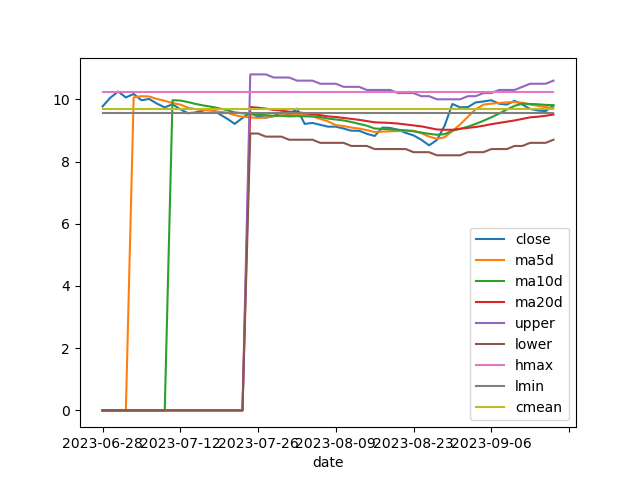

In [70]:
code
tdf = tdd.get_tdx_Exp_day_to_df(code, dl=60).sort_index(ascending=True)
cname = tdd.get_sina_data_code(code)
# plt.title(
#     stock_code + " | " + cname + " | " + str(quotes.index[-1])[: 10],
#     fontsize=14)
tdf.loc[:, ["close", "ma5d", "ma10d", "ma20d",
            "upper", "lower", "hmax", 'lmin', 'cmean']].plot()

In [71]:
tdf[tdf.columns[(tdf.columns >= "perc1d") & (tdf.columns <= "perc9d")]][-1:]

,perc1d,perc2d,perc3d,perc4d,perc5d,perc6d,perc7d,perc8d,perc9d
date,,,,,,,,,
2023-09-18,1.1,0.0,0.0,-0.1,1.0,1.0,1.0,1.0,1.0


In [72]:
tdf[tdf.columns[(tdf.columns >= "per1d") & (tdf.columns <= "per9d")]][-1:]

,per1d,per2d,per3d,per4d,per5d,per6d,per7d,per8d,per9d
date,,,,,,,,,
2023-09-18,1.9,-0.2,-0.5,-1.4,-1.2,1.2,-0.3,-1.1,0.4
